---
authors:
  - name: Anderson Liew 
    affiliation: University of Washington
    email: jeanliew@uw.edu
    github: https://github.com/andersliew/realestateasset.git
    linkedin: https://www.linkedin.com/in/anderson-liew-ab44b0206/
---

# Real Estate Asset Price Correlation

This project examines how housing prices are related to MRT proximity, property age, and neighborhood amenities such as convenience stores. I use statistical hypothesis testing (correlation tests and a t-test) to validate these relationships, and I also train a simple XGBoost model to see how well housing prices can be predicted from these features.

### Research Questions
1. How much does housing proximity to the metro (MRT) change real estate prices?
   - Details: I measured the relationship between MRT distance and housing price using a Pearson correlation test to see how distance affects price. 
   - ANS: MRT proximity has a statistically significant negative relationship with housing price. Homes closer to MRT stations are priced higher.
2. Does the age of real estate moderate the effect of transit access on price?
   - Details: I tested to see if newer houses are more or less sensitive in pricing when compared to proximity to the MRT.
   - ANS: Although age does change the effect of the MRT effect (newer homes are slightly more sensitive to MRT distance), the overall pattern is similar across all age groups.
3. How do neighborhood variables relate to housing prices after accounting for MRT proximity and age?
   - Details: I compared prices between low-store (0-3) and high-store (4+) neighborhoods using a t-test to check whether store availability is associated with higher prices.  
   - ANS: Neighborhoods with more stores have significantly higher housing prices, and the difference is statistically significant.

## Motivation

As an international student from Taiwan, this dataset is the perfect opportunity to determine if public transportation truly has a substantial effect on housing prices. Especially in larger cities like Taipei, it's strongly believed that they do, and this project would help me understand more than just the assumptions made by the general public. Having a trustworthy source of data and evidence to back up this finding would help affirm the presumptions made.

## Data Setting

Dataset: Real Estate Valuation  
Source: https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set

Columns used:
- X1 transaction date (year.fraction) -> `date`
- X2 house age (years) -> `age_yrs`
- X3 distance to nearest MRT (meters) -> `mrt_m`
- X4 number of convenience stores -> `stores`
- X5 latitude -> `lat`
- X6 longitude -> `lon`
- Y house price of unit area (10,000 NTD per Ping) -> `price_ping`

Potential Complications:
- Location differences: Some locations are pricier because of the school or area, which could downplay the public transportation proximity effect.
- Time changes: Different years in the dataset require accounting for inflation if using all years.
- Unconventional units: "Ping" is a standard unit of measurement used in some Asian countries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install xgboost
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
def load_real_estate(path):
    df = pd.read_csv(path)
    df = df.rename(columns={
        'X1 transaction date': 'date',
        'X2 house age': 'age_yrs',
        'X3 distance to the nearest MRT station': 'mrt_m',
        'X4 number of convenience stores': 'stores',
        'X5 latitude': 'lat',
        'X6 longitude': 'lon',
        'Y house price of unit area': 'price_ping'
    })
    
    df = df[['date', 'age_yrs', 'mrt_m', 'stores', 'lat', 'lon', 'price_ping']]
    return df

df = load_real_estate('real_estate_eval.csv')
df

,date,age_yrs,mrt_m,stores,lat,lon,price_ping
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...
409,2013.000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0
411,2013.250,18.8,390.96960,7,24.97923,121.53986,40.6
412,2013.000,8.1,104.81010,5,24.96674,121.54067,52.5


In [3]:
df.isnull().sum()

date          0
age_yrs       0
mrt_m         0
stores        0
lat           0
lon           0
price_ping    0
dtype: int64

In [4]:
df.describe()

,date,age_yrs,mrt_m,stores,lat,lon,price_ping
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


## Method

### Data Loading and Preparation

I used a helper function `load_real_estate(path)` to read the CSV into a DataFrame and renamed the columns to shorter names: `date`, `age_yrs`, `mrt_m`, `stores`, `lat`, `lon`, and `price_ping`. These are the only columns I kept from the original dataset.  
`load_real_estate` is a data-manipulation function, and I tested it on a small sample file to ensure the column names and data types matched my expectations.

### Exploratory Data Analysis

First, I checked the dataset's structure to understand what each row represents and confirmed that there were no missing values. I ran `df.describe()` to summarize the main numeric columns (price, age, MRT distance, stores, latitude, longitude) and used those numbers to get a sense of the typical ranges and variation before doing any modeling.

I then identified which variables are tied to each research question:

- `price_ping` is the outcome variable for all research questions.
- `mrt_m` is used for the first research question about transit proximity.
- `age_yrs` is used for the second research question about how age has the MRT effect.
- `stores` is used for the third research question about neighborhood amenities.
- `lat`, `lon`, and `date` are treated as basic context variables.

For visualization, I wrote three plotting functions:

- `plot_mrt_vs_price(df)`: scatter plot of MRT distance vs price to show the relationship for research question 1.
- `plot_age_price_mrt(df)`: scatter plot of age vs price, colored by MRT distance, to show how age and MRT interact for research question 2.
- `plot_price_by_stores(df)`: box plot of price across different store counts to show how neighborhood amenities relate to price for research question 3.

These plotting functions are tested with assertion tests, and I also used visual inspection to confirm that the axes, labels, and filters were correct.

### Statistical Hypothesis Testing (Challenge Goal 1)

After each visualization, I used statistical tests to validate the patterns I saw in the plots:

- For research question 1, I ran a Pearson correlation test between `mrt_m` and `price_ping` to measure the effect MRT distance has on price and tested whether the correlation is statistically significant.
- For research question 2, I split the data into two groups (newer houses with `age_yrs < 15` and older houses with `age_yrs ≥ 15`) and computed the Pearson correlation between `mrt_m` and `price_ping` separately for each group. I then compared the two correlations to determine whether age affects the strength of the MRT effect.
- For research question 3, I used a two-sample t-test to compare `price_ping` between low-store neighborhoods (0–3 stores) and high-store neighborhoods (4+ stores). This tested whether the mean price differs between areas with fewer vs more stores.

In each case, the EDA plots were used to check the assumptions (linearity in visualization, large enough group sizes, and independence for the t-test). The hypothesis tests directly supported the answers in the results section.

### Modeling with XGBoost (Challenge Goal 2)

For the advanced modeling part, I trained an XGBoost regression model to predict housing prices using log-transformed prices as the target. I created a simple table by copying the main DataFrame and adding:

- `price_log = log(price_ping)`
- `mrt_log = log(mrt_m)`

I then used the following columns as input features: `mrt_log`, `age_yrs`, `stores`, `lat`, and `lon`. I split the data into an 80/20 train–validation split using `train_test_split` and fit a single `XGBRegressor` model. This showed me how well these variables could predict housing prices.

## EDA Results

**What steps did you take during your EDA that prepared the work you conducted for the rest of your analysis?**
I started by loading and cleaning the dataset, checking for missing values, and confirming that all seven columns were usable. Then I summarized the data using df.describe() to see basic statistical variables. These helped me figure out which tests and variables were worth focusing on later when I start modeling and testing hypotheses.

**What did you learn about your data from doing the EDA?**
I learned that the dataset was already clean, which made it easy to work with. Prices dropped as MRT distance increased, and newer houses tended to be priced higher. I also saw that areas with more convenience stores usually had higher prices, showing that location and public amenities both matter.

**How did your understanding of the data setting change?**
At first, I thought MRT proximity alone would explain most price changes. But after exploring the data, I realized that housing age and local amenities also play a big role. I also understood that the dataset only covers a short time frame, so price differences mostly come from location rather than housing market changes over time.

### How large is your dataset

The real estate evaluation dataset that I chose for this project has 414 rows and 7 columns. Each row represents a single property transaction, and each column describes a specific feature about that property. The columns are:

`date`: transaction date

`age_yrs`: age of the house in years

`mrt_m`: distance to the nearest MRT station in meters

`stores`: number of convenience stores nearby

`lat`: latitude

`lon`: longitude

`price_ping`: house price per unit area, measured in 10,000 NTD per ping

### Does your dataset have any missing data?

I checked for missing values in all columns and confirmed there weren't any using df.isnull().sum() under the Data Setting category above this section. 

### What are the variables of interest for your research question?

`price_ping`: dependent variable representing housing price

`mrt_m`: independent variable for Research Question 1 about transit proximity

`age_yrs`: variable for Research Question 2 about how age affects the MRT effect

`stores`: variable for Research Question 3 about neighborhood amenities

### Give a summary of each variable of interest.

To understand the data structure and range, I used df.describe() to generate a summary under the Data Setting category above this section. The table showing the summary is shown above.

### Create at least 2 visualizations

I created 3 visualizations based on each of my research topics below in the Results category shown under this section.

### Result validity only

**Research Question 1: How much does housing proximity to the metro (MRT) change real estate prices?**

Null Hypothesis: There is no correlation between MRT distance and price (p = 0)

Alternative Hypothesis: MRT distance and price are correlated (p /= 0)

Test: Pearson correlation

Assumptions:

- MRT distance and price are more or less linear.
- Each house sale is independent.
- The sample size is large enough so normality doesn’t matter.

Verification: The scatter plot plot_mrt_vs_price(df) shows that prices go down as MRT distance increases, which looks like a clear negative line. Each data point is a different house, so independence makes sense. There are 414 total rows, which is enough data to assume normality.

**Research Question 2: Does the age of real estate moderate the effect of transit access on price?**

Null Hypothesis: The correlation between MRT distance and price is the same for newer houses (age < 15) and older houses (age >= 15)

Alternative Hypothesis: The correlation between MRT distance and price is different between newer and older houses

Test: Compare correlation values for two groups

Assumptions:

- Both newer and older groups are more or less linear.
- The two groups don’t overlap and are independent.
- The sample size is large enough so normality doesn’t matter.

Verification: The scatter plot plot_age_price_mrt(df) shows that newer and older houses both have negative trends between MRT distance and price. The data points are all separate houses, so independence is fine, and both groups have enough houses for the test.

**Research Question 3: Do neighborhoods with more convenience stores have higher housing prices?**

Null Hypothesis: The mean housing price is the same in low-store neighborhoods (0–3 stores) and high-store neighborhoods (4+ stores)

Alternative Hypothesis: The avg housing price is different between the two groups 

Test: Two-sample t-test comparing housing prices in the low-store group and the high-store group

Assumptions:

- Each property sale is independent.  
- The sample size is large enough so normality doesn’t matter.  
- The two groups may have unequal variances, so a t-test is fine.

Verification: The boxplot plot_store_price_box(df) shows that neighborhoods with more stores have higher median prices, and that distribution is different between groups. Both groups have more than 30 observations, supporting the normality assumption. Independence is also fine because each row represents a separate sale.

## Results

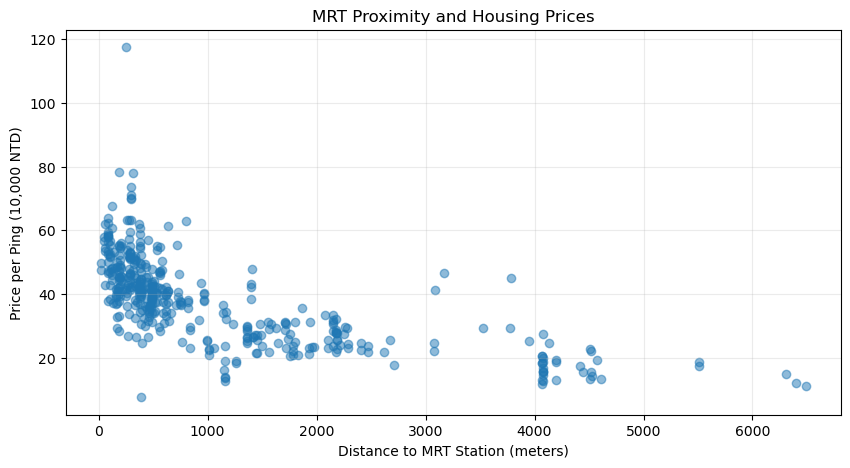

In [5]:
def plot_mrt_vs_price(df):
    """
    This function takes in real estate data to return
    a scatter plot comparing MRT distance vs housing price.
    """
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.scatter(df['mrt_m'], df['price_ping'], alpha = 0.5)
    ax.set_xlabel('Distance to MRT Station (meters)')
    ax.set_ylabel('Price per Ping (10,000 NTD)')
    ax.set_title('MRT Proximity and Housing Prices')
    ax.grid(True, alpha = 0.25)
    plt.show()
    return ax

ax = plot_mrt_vs_price(df)
assert len(ax.collections) == 1, "Expected one scatter plot"
assert ax.get_xlabel() == 'Distance to MRT Station (meters)', "x label mismatch"
assert ax.get_ylabel() == 'Price per Ping (10,000 NTD)', "y label mismatch"
assert ax.get_title() == 'MRT Proximity and Housing Prices', "title mismatch"

**Caption:** Houses closer to MRT stations have higher prices, showing a clear negative relationship between distance and property value.

**Alt text:** Scatter plot with MRT distance (0-6500) on x-axis and price (0-120) on y-axis. Points form a downward slope, with a cluster of expensive properties (40-80) near 0-500 meters from MRT. The cluster decreases as distance increases, with most properties beyond 4000 meters priced below 30.

**Brief paragraph:** This plot shows the relationship between MRT distance and price, which is what my first research question is about. I used a scatter plot because both variables are continuous, and I want to see the overall trend. The main takeaway is that proximity to MRT stations is associated with higher prices, and properties within 500 meters of a station are more expensive than those farther away. However, there's still variation at all distances, suggesting other factors also matter.

In [6]:
def test_correlation(x, y):
    """
    This function runs a Pearson correlation test between two variables and returns the
    correlation coefficient as well as the p-value.
    """
    r, p = stats.pearsonr(x, y)
    print("Correlation:", r)
    print("P-value:", p)
    return r, p

r, p = test_correlation(df["mrt_m"], df["price_ping"])
assert -1 <= r <= 1
assert 0 <= p <= 1

Correlation: -0.6736128553689182
P-value: 4.639825030361503e-56


**Statistical Hypothesis Testing Result: Pearson Correlation (Challenge Goal 1)**

This Pearson correlation test shows a strong negative correlation, and since the p-value is below 0.05, we reject the null hypothesis. This means the MRT distance is statistically associated with housing prices. Generally, houses closer to MRT stations are much more expensive, and prices drop as distance increases. This matches the pattern in the scatter plot above, where the most expensive houses are near the MRT. (note that there are still outside factors resulting in variation)

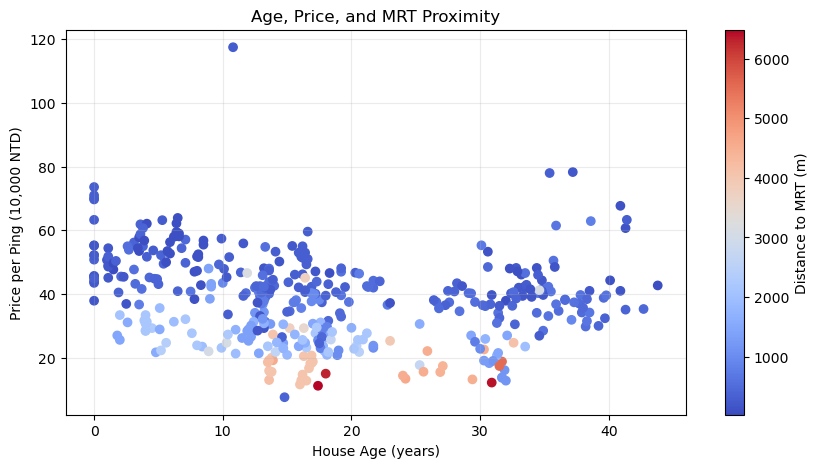

In [7]:
def plot_age_price_mrt(df):
    """
    This function takes in real estate data to return a 
    scatter plot of house age vs price, colored by MRT distance.
    """
    fig, ax = plt.subplots(figsize = (10, 5))
    scatter = ax.scatter(df['age_yrs'], df['price_ping'], c = df['mrt_m'], cmap = 'coolwarm')
    plt.colorbar(scatter, label = 'Distance to MRT (m)')
    ax.set_xlabel('House Age (years)')
    ax.set_ylabel('Price per Ping (10,000 NTD)')
    ax.set_title('Age, Price, and MRT Proximity')
    ax.grid(True, alpha = 0.25)
    plt.show()
    return ax

ax = plot_age_price_mrt(df)
assert len(ax.collections) == 1, "Expected one scatter plot"
assert ax.get_xlabel() == 'House Age (years)', "x label mismatch"
assert ax.get_ylabel() == 'Price per Ping (10,000 NTD)', "y label mismatch"
assert ax.get_title() == 'Age, Price, and MRT Proximity', "title mismatch"

**Caption:** Older houses generally cost less, but MRT proximity helps maintain value even as houses age.

**Alt text:** Scatter plot with house age (0-45) on the x-axis and price on the y-axis. Points are colored by MRT distance. Dark red means farther, and dark blue means closer to MRT. Dark blue points concentrate in the upper left and show higher prices across ages, meaning that younger, closer houses cost more. Bright red points cluster mostly at lower prices, around ages 15-35 years.

**Brief paragraph:** This visualization addresses my second research question about whether age affects the MRT effect. I added color to show MRT distance with age and price. We can see that properties near the MRT maintain higher prices even as they age, whereas properties farther from the MRT are cheaper, regardless of age. This tells us that MRT proximity can help a property preserve its value.

In [8]:
def test_correlation_age_groups(df):
    """
    This function runs a Pearson correlation for MRT vs price for newer and older homes, and
    returns the correlation coefficient and p-value for both groups.
    """
    newer = df[df["age_yrs"] < 15]
    older = df[df["age_yrs"] >= 15]

    print("Newer homes (<15 years)")
    r_new, p_new = test_correlation(newer["mrt_m"], newer["price_ping"])
    print()

    print("Older homes (>=15 years)")
    r_old, p_old = test_correlation(older["mrt_m"], older["price_ping"])
    print()
    
    return (r_new, p_new), (r_old, p_old)

(r_new, p_new), (r_old, p_old) = test_correlation_age_groups(df)
assert -1 <= r_new <= 1
assert -1 <= r_old <= 1
assert 0 <= p_new <= 1
assert 0 <= p_old <= 1

Newer homes (<15 years)
Correlation: -0.6962771004726156
P-value: 6.993470257056329e-29

Older homes (>=15 years)
Correlation: -0.679734770859146
P-value: 1.0162761458894464e-31



**Statistical Hypothesis Testing Result: Computing and Comparing Correlation (Challenge Goal 1)**

Both correlations are negative and statistically significant. Since the p-values for both the newer and older groups are below 0.05, we reject the null hypothesis. This means the relationship between MRT distance and price differs between the two age groups (newer homes have a slightly higher correlation, but MRT distance affects price for both newer and older properties overall).

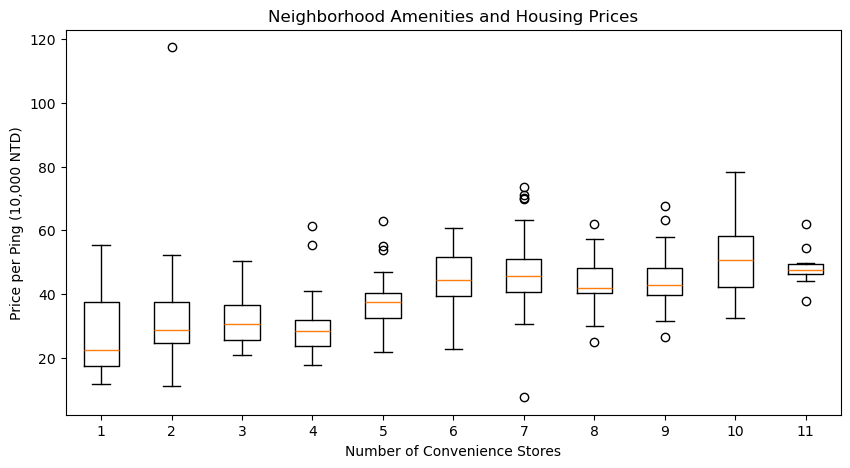

In [9]:
def plot_store_price_box(df):
    """
    This function takes in real estate data to return a 
    box plot of price vs number of nearby convenience stores.
    It returns (ax, bp) where bp is the dictionary from ax.boxplot.
    """
    fig, ax = plt.subplots(figsize = (10, 5))

    box_data = []
    for i in range(11):
        prices = df[df["stores"] == i]["price_ping"]
        box_data.append(prices)

    bp = ax.boxplot(box_data)
    ax.set_xlabel('Number of Convenience Stores')
    ax.set_ylabel('Price per Ping (10,000 NTD)')
    ax.set_title('Neighborhood Amenities and Housing Prices')
    plt.show()
    return ax, bp

ax, bp = plot_store_price_box(df)
assert len(bp['boxes']) == 11, "expected 11 boxes (0..10 stores)"
assert ax.get_xlabel() == 'Number of Convenience Stores', "x label mismatch"
assert ax.get_ylabel() == 'Price per Ping (10,000 NTD)', "y label mismatch"
assert ax.get_title() == 'Neighborhood Amenities and Housing Prices', "title mismatch"

**Caption:** Properties with more nearby convenience stores show higher median prices, suggesting neighborhood amenities add value to houses.

**Alt text:** Box plot showing price distributions for each count of nearby stores (0-11) on the x-axis. Median prices show variation but generally trend up. The pattern isn't perfectly straight, and there are multiple outlier points (the circles above the boxes).

**Brief summary:** This plot addresses my third research question about how neighborhood amenities relate to housing prices. I used a box plot because the number of stores makes it easier to show the full price distribution at each level, compared to a scatter plot. The main thing is that more stores mean higher house prices, and houses with more than 5 stores tend to have higher median prices than those with fewer stores.

In [10]:
def test_ttest(low, high):
    """
    This function runs a two-sample t-test comparing low-store vs high-store prices, and returns 
    a value t-stat (difference between the two groups) and p-value.
    """
    t, p = stats.ttest_ind(low, high)
    print("t-stat:", t)
    print("P-value:", p)
    return t, p

low = df[df["stores"] <= 3]["price_ping"]
high = df[df["stores"] >= 4]["price_ping"]
t_stat, p_val = test_ttest(low, high)
assert 0 <= p_val <= 1

t-stat: -14.17974772808495
P-value: 1.8907582659089722e-37


**Statistical Hypothesis Testing Result: t-test (Challenge Goal 1)**

This two-sample t-test compares the average housing prices between neighborhoods with fewer stores (0–3) and those with more stores (4+). The result shows a p-value below 0.05, so we reject the null hypothesis. The t-stat result also confirms that there's a big difference between low and high neighborhood store housing prices. This basically means the two groups have different average prices and matches how the boxplot shows median price rising when the number of stores reaches four or more (note that there are still outside factors resulting in variation).

In [12]:
def test_xgboost(df):
    """
    This function fits an XGBoost model on log-transformed data and returns RMSE, MAE, and R^2.
    """
    df["price_log"] = np.log(df["price_ping"])
    df["mrt_log"] = np.log(df["mrt_m"])

    X = df[["mrt_log", "age_yrs", "stores", "lat", "lon"]]
    y = df["price_log"]
    X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size = 0.2)
    model = XGBRegressor(objective = "reg:squarederror")
    model.fit(X_tr, y_tr)

    preds = model.predict(X_va)
    rmse = mean_squared_error(y_va, preds, squared=False)
    mae = mean_absolute_error(y_va, preds)
    r2 = r2_score(y_va, preds)

    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R^2:", r2)
    return rmse, mae, r2

rmse, mae, r2 = test_xgboost(df)
assert rmse > 0
assert mae > 0
assert -1 <= r2 <= 1

RMSE: 0.1639451779366615
MAE: 0.11812205680624652
R^2: 0.7786511143180626


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Advanced Machine Learning: XGBoost (Challenge Goal 2)**

XGBoost builds decision trees step by step, with each one fixing the previous one's prediction mistakes. For the XGBoost model, I first created a simple table and split it into training and validation sets. I then trained it using the variables I had created earlier and checked how well it performed on a single validation set. The result for the time I ran it was that RMSE and MAE are both pretty low (the lower RMSE and MAE are, the better), and R^2 is about 0.78. However, results may vary each time the model is rerun.

- RMSE measures how far off my model's predictions were on avg
- MAE measures the size of the mistakes the model makes
- R^2 measures how much of the variation in prices the model is able to account for

This basically means the model explains around 78% of the variation in housing prices. Although it isn’t perfect since prices are affected by a lot of things that aren’t in the dataset, the model basically confirms that MRT distance, age, and neighborhood stores all have measurable effects on price.

## Implications and Limitations

Through this project, homebuyers and real estate professionals can gain a deeper understanding of factors that may influence housing price changes. However, people not living in these areas might find this less relevant, and it might even negatively impact housing prices in regions that didn't have such high prices to begin with. Though a bit of a stretch, this could potentially harm lower-income residents renting near public transportation. Data setting significantly helped me with visualization, since I compiled the rows and columns I used into a smaller, more relevant dataset. I also renamed the column names so it's easier to see what the results mean. Moreover, in terms of limitations, this dataset has a small sample size and may miss other important variables that come into play when looking at housing prices. Also, this project only explores relations between variables, and does not mean any cause and effect situations. Based on these limitations, the results should only be seen as patterns in the specific region of Taipei, and a stronger analysis on a larger dataset with more variables is needed to achieve concrete answers.

## Challenge Goals

**Challenge Goal 1: Statistical Hypothesis Testing**

I ran a Pearson correlation test to confirm that MRT distance has an effect on housing price, and then calculated the same correlation separately for newer and older houses to see whether age changes the strength of that relationship. I also used a two-sample t-test to compare housing prices in low-store neighborhoods vs high-store neighborhoods. These tests allowed me to check whether the patterns I saw in the three visualizations I made were meaningful.

**Challenge Goal 2: Advanced Machine Learning: XGBoost**

I also trained a basic XGBoost regression model to predict housing prices using log-transformed prices as the target. I created a small feature table, split it into training and validation sets, and fit a single XGBRegressor model. I then evaluated it using RMSE, MAE, and R^2 to get a sense of how well the model explained variation in housing prices. 

**Changes from proposal:**

I originally planned to use Altair for interactive visualizations, but switched to statistical hypothesis testing instead. I made this change because the final deliverable is a PDF where interactive features wouldn't work anyway, and hypothesis testing provides stronger statistical evidence for my research questions.

## Plan Evaluation

My original time estimates were mostly accurate for the basic tasks, but it turns out I didn't account for everything. My estimates were off mainly because I underestimated how long it takes to write explanations.

Data loading and cleaning: estimated 3 hours, took about 2 hours. The dataset had no missing values, so I didn't need to spend time handling them. 

Visualizations and interpretations: estimated 3-4 hours, took around 6 hours. I spent a lot of time making sure all visualization plots looked good and writing detailed explanations for each one. 

Statistical hypothesis testing and XGBoost: estimated 9 hours, took me 7 hours instead. I thought the tests would take longer, but they ended up taking a bit less time because I took a class on core methods in data science over the summer. 

## Testing

For my visualizations, I included docstrings under each function so readers can get a better gist of what the code does. I also included simple assert tests under each function, which run every time the block of code is executed. Tests like checking the correct variable for the labels in my plot and determining how many boxes in the box plot are expected are examples of the tests I used. For the dataset itself, I checked for any issues that needed cleaning using the isnull() function. This dataset is trustworthy because it comes from UC Irvine and was collected a few years ago from now.